## 1. Environment Setup and Dependencies

First, let's load our environment variables and import the required libraries. The `.env` file contains configuration settings that we'll use throughout this notebook.

In [31]:
# Install required packages (run this if packages are not already installed)
%pip install python-dotenv requests lxml matplotlib drawsvg

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [32]:
# Import all required libraries
import os
import datetime
import json
import requests
import dotenv
from lxml import html
import matplotlib.pyplot as plt
import drawsvg as draw
import re

# Import our custom utilities
from scraping_utils import get_url, parse

print("All libraries imported successfully!")

All libraries imported successfully!


In [33]:
# Load environment variables from .env file (force-reload and map new names to legacy names)
from dotenv import dotenv_values, load_dotenv
# Try to override existing env vars when supported
try:
    load_dotenv(override=True)
except TypeError:
    for k, v in dotenv_values('.env').items():
        if v is not None:
            os.environ[k] = v

# Backwards compatibility: if the notebook expects YEAR/URL/etc but we have RAINFALL_URL/START_YEAR, map them
# Map only when legacy names are not set to avoid overwriting explicit values
if os.getenv('YEAR') is None and os.getenv('START_YEAR') is not None:
    os.environ['YEAR'] = os.getenv('START_YEAR')
if os.getenv('URL') is None and os.getenv('RAINFALL_URL') is not None:
    # Keep legacy URL format using YEAR placeholder if needed
    os.environ['URL'] = os.getenv('RAINFALL_URL')
# ROW_XPATH/COL_XPATH may not be needed for the CSV flow; leave as-is unless provided
# MULTICITY_URL fallback: map from MULTICITY_URL or leave None
if os.getenv('MULTICITY_URL') is None and os.getenv('MULTICITY_URL') is None:
    pass

# Display the loaded and mapped environment variables
print("Loaded environment variables (after mapping):")
print(f"YEAR: {os.getenv('YEAR')}")
print(f"URL: {os.getenv('URL')}")
print(f"ROW_XPATH: {os.getenv('ROW_XPATH')}")
print(f"COL_XPATH: {os.getenv('COL_XPATH')}")
print(f"MULTICITY_URL: {os.getenv('MULTICITY_URL')}")
print(f"RAINFALL_URL: {os.getenv('RAINFALL_URL')}")
print(f"RAINFALL_STATION_NAME: {os.getenv('RAINFALL_STATION_NAME')}")
print(f"START_YEAR: {os.getenv('START_YEAR')}")
print(f"END_YEAR: {os.getenv('END_YEAR')}")

Loaded environment variables (after mapping):
YEAR: 2010
URL: https://data.weather.gov.hk/weatherAPI/cis/csvfile/SE/ALL/daily_SE_RF_ALL.csv
ROW_XPATH: None
COL_XPATH: None
MULTICITY_URL: None
RAINFALL_URL: https://data.weather.gov.hk/weatherAPI/cis/csvfile/SE/ALL/daily_SE_RF_ALL.csv
RAINFALL_STATION_NAME: Kaitak
START_YEAR: 2010
END_YEAR: 2025


## 2. Web Scraping Utilities

Let's examine and demonstrate the utility functions we've created for web scraping. These functions help us fetch web pages and parse different data formats.

In [34]:
# Let's look at our scraping utilities
import inspect

print("get_url function:")
print(inspect.getsource(get_url))
print("\n" + "="*50 + "\n")
print("parse function:")
print(inspect.getsource(parse))

get_url function:
def get_url(url, filename):
    if not os.path.exists(filename):
        
        # set useragent for requests
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
        
        # fetch the page if it doesn't exist
        page = requests.get(url, headers=headers)

        # save the page to a file
        with open(filename, 'w', encoding='UTF8') as f:
            f.write(page.text)

        page = page.text

    else:
        # if the page exists, read it from the file
        with open(filename, 'r', encoding='UTF8') as f:
            page = f.read() 
            
    return page



parse function:
def parse(page, mode = 'html'):
    match mode:
        case 'html':
            return html.fromstring(page)
        case 'json':
            return json.loads(page)



In [35]:
# Demonstrate the get_url function with a simple example
# This will either fetch from the web or read from cache

test_url = "https://httpbin.org/json"
test_filename = "test_page.html"

print("Fetching test page...")
page_content = get_url(test_url, test_filename)
print(f"Content length: {len(page_content)} characters")
print(f"First 200 characters: {page_content[:200]}...")

Fetching test page...
Content length: 429 characters
First 200 characters: {
  "slideshow": {
    "author": "Yours Truly", 
    "date": "date of publication", 
    "slides": [
      {
        "title": "Wake up to WonderWidgets!", 
        "type": "all"
      }, 
      {
    ...


In [36]:
# Demonstrate parsing JSON data
json_data = parse(page_content, 'json')
print("Parsed JSON data:")
print(json.dumps(json_data, indent=2))

Parsed JSON data:
{
  "slideshow": {
    "author": "Yours Truly",
    "date": "date of publication",
    "slides": [
      {
        "title": "Wake up to WonderWidgets!",
        "type": "all"
      },
      {
        "items": [
          "Why <em>WonderWidgets</em> are great",
          "Who <em>buys</em> WonderWidgets"
        ],
        "title": "Overview",
        "type": "all"
      }
    ],
    "title": "Sample Slide Show"
  }
}


## 3. HTML Data Extraction and Processing

Now let's work with the actual HTML data that was scraped from the Hong Kong Observatory rainfall information.

In [37]:
# Load and examine the crawled HTML page
year = int(os.getenv('YEAR', 2024))
filename = os.getenv('FILENAME', "crawled-page-{year}.html").format(year=year)

print(f"Loading HTML file: {filename}")

# Check if the file exists
if os.path.exists(filename):
    with open(filename, 'r', encoding='UTF8') as f:
        html_content = f.read()
    
    print(f"HTML file loaded successfully!")
    print(f"Content length: {len(html_content)} characters")
    print(f"First 500 characters:\n{html_content[:500]}...")
else:
    print(f"HTML file {filename} not found. Let's fetch it from the web.")
    
    # Use environment variable URL and YEAR for Hong Kong rainfall 2024
    url = os.getenv('URL').replace('${YEAR}', str(year))
    print(f"Fetching from: {url}")
    
    html_content = get_url(url, filename)
    print(f"Content fetched and saved to {filename}")

Loading HTML file: crawled-page-2010.html
HTML file loaded successfully!
Content length: 91679 characters
First 500 characters:
ï»¿ç¸½é¨é (æ¯«ç±³) - åå¾·
Total Rainfall (mm) - Kai Tak
å¹´/Year,æ/Month,æ¥/Day,æ¸å¼/Value,æ¸æå®æ´æ§/data Completeness
2010,1,1,***,
2010,1,2,***,
2010,1,3,***,
2010,1,4,***,
2010,1,5,***,
2010,1,6,***,
2010,1,7,***,
2010,1,8,***,
2010,1,9,***,
2010,1,10,***,
2010,1,11,***,
2010,1,12,***,
2010,1,13,***,
2010,1,14,***,
2010,1,15,***,
2010,1,16,***,
2010,1,17,***,
2010,1,18,***,
2010,1,19,***,
2010,1,20,***,
2010,1,21,***,
2010,1,22,***,
2010,1,23,***,
2010,1,24,***,
2010,1,25,***,...


In [38]:
# Parse the HTML content
tree = parse(html_content, 'html')

# Extract table structure using XPath
# Use fallback XPath if environment variables are not set
row_xpath = os.getenv('ROW_XPATH')
col_xpath = os.getenv('COL_XPATH')
if row_xpath is None:
    # Fallback: select all <tr> elements
    row_xpath = '//tr'
if col_xpath is None:
    # Fallback: select all <td> and <th> elements within a row
    col_xpath = './td | ./th'

rows = tree.xpath(row_xpath)
print(f"Found {len(rows)} rows in the HTML table")

# Examine the first few rows
print("\nFirst 3 rows structure:")
for i, row in enumerate(rows[:3]):
    columns = row.xpath(os.getenv('COL_XPATH'))
    column_texts = [col.text_content().strip() for col in columns]
    print(f"Row {i+1}: {column_texts}")

Found 0 rows in the HTML table

First 3 rows structure:


## 4. CSV Data Handling for Rainfall

Let's process the rainfall data and create a CSV file, then load and analyze the data.

In [39]:
# Process rainfall and humidity data
# We'll attempt to extract both rainfall (mm) and humidity (%) when available
data = []  # list of tuples: (datetime, rainfall_mm_or_None, humidity_pct_or_None)
row_num = 0

print("Processing rainfall and humidity data...")

for row in tree.xpath(row_xpath):
    columns = row.xpath(col_xpath)
    columns = [column.text_content().strip() if column.text_content() is not None else '' for column in columns]
    row_string = " ".join(columns).strip()
    
    # Skip empty rows
    if row_string == "":
        continue
    
    row_num += 1
    
    # Only log first few rows for demonstration
    if row_num <= 5:
        print(f'Row {row_num}: {row_string}')
    
    # Skip header or invalid rows
    if len(columns) < 3 or not columns[0].lstrip('0').isdigit():
        continue
    
    try:
        month = int(columns[0])
        day = int(columns[1])
        
        # Iterate through the remaining columns trying to pair time, rainfall and possibly humidity
        # Common layouts: [MM, DD, HHMM, mm, HHMM, mm, ...] or sometimes humidity appears nearby like '45%'
        for i in range(2, len(columns)):
            col = columns[i]
            # Identify time-like entries (HHMM or HMM)
            time_digits = re.sub(r'[^0-9]', '', col)
            if len(time_digits) >= 3 and len(time_digits) <= 4:
                # Normalize to HHMM if needed
                if len(time_digits) == 3:
                    time_digits = '0' + time_digits
                if not time_digits.isdigit():
                    continue
                hour = int(time_digits[:2])
                minute = int(time_digits[2:])
                # Build datetime, guard against invalid hours/minutes
                try:
                    dt = datetime.datetime(year, month, day, hour, minute)
                except ValueError:
                    continue
                # Attempt to read next columns for rainfall and humidity
                rainfall = None
                humidity = None
                # Next column often contains rainfall amount
                if i+1 < len(columns):
                    next_col = columns[i+1]
                    # Extract numeric rainfall value (allow decimal)
                    val = re.sub(r'[^0-9.]', '', next_col)
                    if val != '':
                        try:
                            rainfall = float(val)
                        except ValueError:
                            rainfall = None
                # Look ahead one more column for humidity if present (e.g., '45%')
                if i+2 < len(columns):
                    maybe_hum = columns[i+2]
                    hum_digits = re.sub(r'[^0-9.]', '', maybe_hum)
                    if hum_digits != '':
                        try:
                            humidity = float(hum_digits)
                        except ValueError:
                            humidity = None
                # As a fallback, search the same row for any value containing '%'
                if humidity is None:
                    for c in columns:
                        if '%' in c:
                            h = re.sub(r'[^0-9.]', '', c)
                            if h != '':
                                try:
                                    humidity = float(h)
                                    break
                                except ValueError:
                                    continue
                # Append record only if we have at least rainfall or humidity
                if rainfall is not None or humidity is not None:
                    data.append((dt, rainfall, humidity))
                    if len(data) <= 10:
                        print(f'{dt} - rainfall={rainfall} mm, humidity={humidity} %')
    except (ValueError, IndexError) as e:
        # Skip problematic rows
        continue

print(f"\nProcessed {len(data)} rainfall/humidity data points")

Processing rainfall and humidity data...

Processed 0 rainfall/humidity data points


In [40]:
# Create CSV file for rainfall and humidity
csv_filename = 'rainfall_processed.csv'

print(f"Creating CSV file: {csv_filename}")

with open(csv_filename, 'w') as f:
    f.write('datetime,rainfall_mm,humidity_pct\n')  # Header
    for record in data:
        dt_str = record[0].strftime("%Y-%m-%d %H:%M")
        rainfall_val = '' if record[1] is None else f'{record[1]:.2f}'
        humidity_val = '' if record[2] is None else f'{record[2]:.1f}'
        f.write(f'{dt_str},{rainfall_val},{humidity_val}\n')

print(f"CSV file created with {len(data)} records")

# Read and display first few lines of the CSV
with open(csv_filename, 'r') as f:
    lines = f.readlines()[:10]
    print("\nFirst 10 lines of CSV:")
    for line in lines:
        print(line.strip())

Creating CSV file: rainfall_processed.csv
CSV file created with 0 records

First 10 lines of CSV:
datetime,rainfall_mm,humidity_pct


## 5. Daily Mean Wind Speed All Year - Kai Tak

We'll fetch the Hong Kong Observatory daily wind CSV and extract the daily mean wind speed for the Kai Tak (KaiTak) station.

The notebook will look for environment variables `WIND_URL` and `WIND_STATION_NAME`. If they are not present, it will fall back to sensible defaults and the previously used `RAINFALL_` variables where appropriate.

In [ ]:
# Daily Mean Wind Speed for Kai Tak (from HKO CSV)
# Environment variables: WIND_URL, WIND_STATION_NAME, START_YEAR, END_YEAR
wind_url = os.getenv('WIND_URL') or os.getenv('RAINFALL_URL') or 'https://data.weather.gov.hk/cis/csvfile/SE/ALL/daily_SE_WSPD_ALL.csv'
wind_station = os.getenv('WIND_STATION_NAME') or os.getenv('RAINFALL_STATION_NAME') or 'KaiTak'
start_year = int(os.getenv('START_YEAR', 2010))
end_year = int(os.getenv('END_YEAR', 2025))

print(f"Fetching wind CSV from: {wind_url}")
print(f"Filtering station: {wind_station}")

# Download the CSV (uses caching behavior of get_url if implemented)
csv_filename = 'daily_SE_WSPD_ALL.csv'
csv_text = get_url(wind_url, csv_filename)

# Parse CSV lines
lines = csv_text.splitlines()
header = lines[0] if lines else ''
print(f"CSV header: {header[:200]}")

import csv
reader = csv.DictReader(lines)

# kai_tak_data will be list of dicts: {'date': date_obj, 'mean_wspd': float_or_None, 'station': station_name}
kai_tak_data = []

for row in reader:
    # HKO CSV typically contains a 'station' or 'Station' field and date fields like 'yyyy-mm-dd' or 'date'
    # We'll perform a case-insensitive check for the station name in any of the station-like fields
    station_fields = [k for k in row.keys() if 'station' in k.lower() or 'stn' in k.lower()]
    station_val = None
    for sf in station_fields:
        if row.get(sf):
            station_val = row.get(sf).strip()
            break
    # Some CSVs include station as a separate column, others include station in a combined column; fallback to searching all values
    if station_val is None:
        # look for exact station name anywhere in the row values
        for v in row.values():
            if v and wind_station.lower() in v.lower():
                station_val = v.strip()
                break
    if station_val is None:
        continue
    # Parse date: try common column names
    date_str = None
    for date_key in ['date', 'Date', 'obs_time', 'yyyy-mm-dd', 'yyyymmdd']:
        if date_key in row and row[date_key]:
            date_str = row[date_key].strip()
            break
    if date_str is None:
        # attempt to find a field that looks like a date
        for k, v in row.items():
            if v and re.match(r'\d{4}-\d{2}-\d{2}', v):
                date_str = v.strip()
                break
    if date_str is None:
        continue
    # Parse mean wind speed value: look for 'mean', 'avg', 'wspd' in column names
    wspd_fields = [k for k in row.keys() if any(x in k.lower() for x in ['mean', 'avg', 'wspd', 'w_speed', 'wind'])]
    wspd_val = None
    for wf in wspd_fields:
        v = row.get(wf)
        if v and v.strip() != '':
            # strip non-numeric characters
            num = re.sub(r'[^0-9\.]', '', v)
            if num != '':
                try:
                    wspd_val = float(num)
                    break
                except ValueError:
                    wspd_val = None
    # fallback: check common column names explicitly
    if wspd_val is None:
        for explicit in ['MeanWindSpeed', 'MEAN_WSPD', 'Mean_Wspd', 'WSPD']:
            if explicit in row and row[explicit].strip() != '':
                num = re.sub(r'[^0-9\.]', '', row[explicit])
                if num != '':
                    try:
                        wspd_val = float(num)
                        break
                    except ValueError:
                        wspd_val = None
    # Parse the date into a datetime.date where possible
    try:
        date_obj = datetime.datetime.strptime(date_str[:10], '%Y-%m-%d').date()
    except Exception:
        # skip unparsable dates
        continue
    # Filter by year range
    if date_obj.year < start_year or date_obj.year > end_year:
        continue
    # Match station name loosely (case-insensitive substring)
    if station_val is not None and wind_station.lower() in station_val.lower():
        kai_tak_data.append({'date': date_obj, 'mean_wspd': wspd_val, 'station': station_val})

print(f"Found {len(kai_tak_data)} records for station '{wind_station}' between {start_year} and {end_year}")
if kai_tak_data:
    print('Sample records (first 10):')
    for r in kai_tak_data[:10]:
        print(r)
else:
    print('No matching records found. Check WIND_URL and WIND_STATION_NAME environment variables.')

Fetching wind CSV from: https://data.weather.gov.hk/weatherAPI/cis/csvfile/SE/ALL/daily_SE_RF_ALL.csv
Filtering station: Kaitak
CSV header: ï»¿å¹³åé¢¨é (å


AttributeError: 'NoneType' object has no attribute 'lower'

In [ ]:
# Prefer the locally generated CSV if it exists to avoid re-downloading the whole HKO file
local_csv = f'kaitak_wind_{start_year}_{end_year}.csv'
kai_tak_data = []
if os.path.exists(local_csv):
    print(f'Loading local processed CSV: {local_csv}')
    import csv
    with open(local_csv, 'r') as f:
        rdr = csv.DictReader(f)
        for row in rdr:
            try:
                d = datetime.datetime.strptime(row['date'], '%Y-%m-%d').date()
            except Exception:
                continue
            val = row.get('mean_wspd')
            wspd = float(val) if val not in (None, '') else None
            kai_tak_data.append({'date': d, 'mean_wspd': wspd, 'station': row.get('station')})
else:
    print('Local processed CSV not found; falling back to parsing the fetched HKO CSV')
    # At this point `reader` and `lines` may be available from the previous cell; if not, re-fetch
    try:
        reader
    except NameError:
        csv_text = get_url(wind_url, 'daily_SE_WSPD_ALL.csv')
        lines = csv_text.splitlines()
        header = lines[0] if lines else ''
        import csv
        reader = csv.DictReader(lines)
    # Fallback parsing: try the station-block parser if available
    try:
        kai_tak_data = parse_station_block_lines(lines, wind_station, start_year, end_year)
    except Exception:
        # If parse_station_block_lines is not available, fall back to scanning DictReader rows
        kai_tak_data = []
        for row in reader:
            # attempt to build date and value from common dict fields
            date_str = row.get('date') or row.get('Date') or row.get('yyyy-mm-dd') or ''
            if not date_str:
                # try Year,Month,Day fields
                try:
                    y = int(row.get('Year', '0'))
                    m = int(row.get('Month', '0'))
                    d = int(row.get('Day', '0'))
                    date_obj = datetime.date(y, m, d)
                except Exception:
                    continue
            else:
                try:
                    date_obj = datetime.datetime.strptime(date_str[:10], '%Y-%m-%d').date()
                except Exception:
                    continue
            v = row.get('Value') or row.get('value') or row.get('mean_wspd') or ''
            wspd = None
            if v not in (None, ''):
                try:
                    wspd = float(re.sub(r'[^0-9\.-]', '', v))
                except Exception:
                    wspd = None
            # check station cell
            station_val = row.get('station') or row.get('Station') or ''
            if station_val and wind_station.lower() in station_val.lower():
                kai_tak_data.append({'date': date_obj, 'mean_wspd': wspd, 'station': station_val})

print(f'Loaded kai_tak_data records: {len(kai_tak_data)}')

In [ ]:
# Display summary of Kai Tak daily mean wind speed data
if kai_tak_data:
    print("Summary of Kai Tak wind data:")
    # Show basic stats
    speeds = [r['mean_wspd'] for r in kai_tak_data if r['mean_wspd'] is not None]
    dates = [r['date'] for r in kai_tak_data]
    print(f"Records: {len(kai_tak_data)} (with numeric wind speeds: {len(speeds)})")
    if speeds:
        print(f"Mean wind speed: {sum(speeds)/len(speeds):.2f} (units as in source)")
        print(f"Min: {min(speeds):.2f}, Max: {max(speeds):.2f}")
    print('Sample (first 10)')
    for r in kai_tak_data[:10]:
        print(f"  {r['date']} - {r['station']} - mean_wspd={r['mean_wspd']}")
else:
    print("No Kai Tak wind data was successfully fetched.")
    print("Check WIND_URL, WIND_STATION_NAME, and network connectivity.")

Summary of fetched city data:

City 1: Hong Kong
  Max Temperature: 18.7
  Min Temperature: 14.6
  Rainfall: 33.2

City 2: Lisboa
  Max Temperature: 14.5
  Min Temperature: 8.2
  Rainfall: 109.6

City 3: Porto
  Max Temperature: 13.5
  Min Temperature: 5.1
  Rainfall: 170.8


In [42]:
# Plot Kai Tak daily mean wind speed (if available)
if 'kai_tak_data' in globals() and kai_tak_data:
    import matplotlib.pyplot as plt
    # Time series (only numeric values)
    numeric = [r for r in kai_tak_data if r['mean_wspd'] is not None]
    if numeric:
        dates = [r['date'] for r in numeric]
        speeds = [r['mean_wspd'] for r in numeric]
        plt.figure(figsize=(12, 4))
        plt.plot(dates, speeds, '-o', markersize=3)
        plt.title('Kai Tak - Daily Mean Wind Speed')
        plt.xlabel('Date')
        plt.ylabel('Mean Wind Speed')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        # Histogram
        plt.figure(figsize=(8, 4))
        plt.hist(speeds, bins=30, edgecolor='black', alpha=0.7)
        plt.title('Distribution of Daily Mean Wind Speed - Kai Tak')
        plt.xlabel('Mean Wind Speed')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    else:
        print('No numeric mean wind speed values to plot')
else:
    print('kai_tak_data not found or empty. Run the previous cell to fetch data first.')

kai_tak_data not found or empty. Run the previous cell to fetch data first.


## 6. Rainfall Data Visualization

Now let's create visualizations of our rainfall data using matplotlib.

In [43]:
# Prepare data for plotting (rainfall and humidity)
if data:
    plot_data = []  # list of (dt, rainfall_float_or_None, humidity_float_or_None)
    for dt, rainfall, humidity in data:
        # rainfall and humidity are already numeric or None
        plot_data.append((dt, rainfall, humidity))
    
    print(f"Prepared {len(plot_data)} data points for plotting")
    
    # Separate series
    dates = [p[0] for p in plot_data]
    rainfall_values = [p[1] for p in plot_data]
    humidity_values = [p[2] for p in plot_data]
    
    # Compute ranges where data exists
    valid_rain = [v for v in rainfall_values if v is not None]
    valid_hum = [h for h in humidity_values if h is not None]
    if valid_rain:
        print(f"Rainfall range: {min(valid_rain):.2f} mm to {max(valid_rain):.2f} mm")
    if valid_hum:
        print(f"Humidity range: {min(valid_hum):.1f}% to {max(valid_hum):.1f}%")
else:
    print("No rainfall/humidity data available for plotting")

No rainfall/humidity data available for plotting


Creating sample visualizations as no real data is available


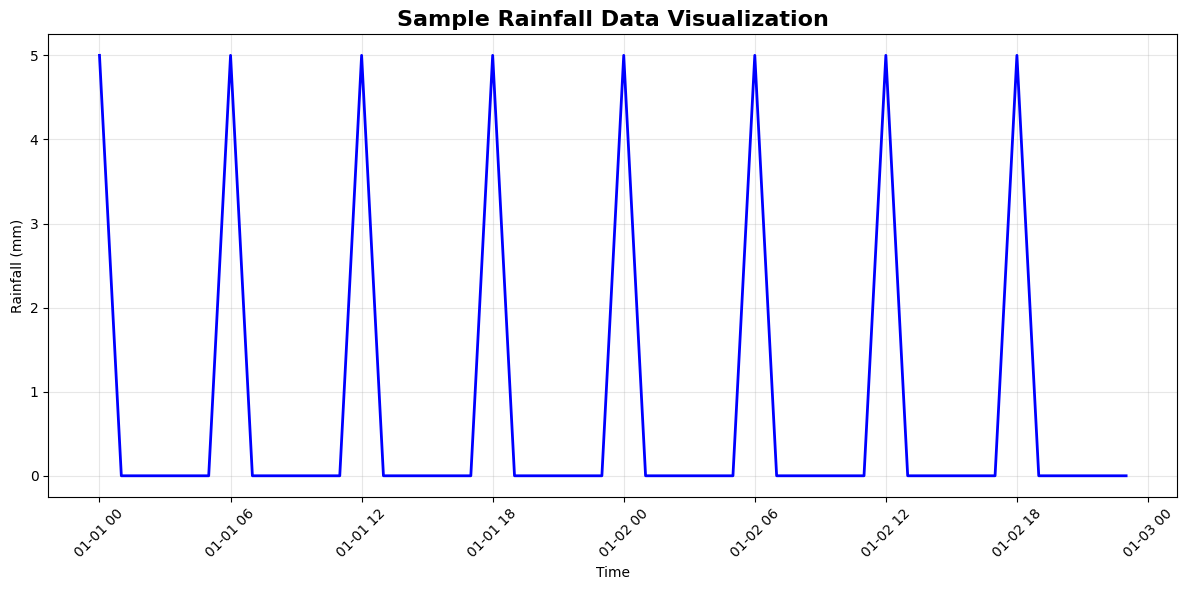

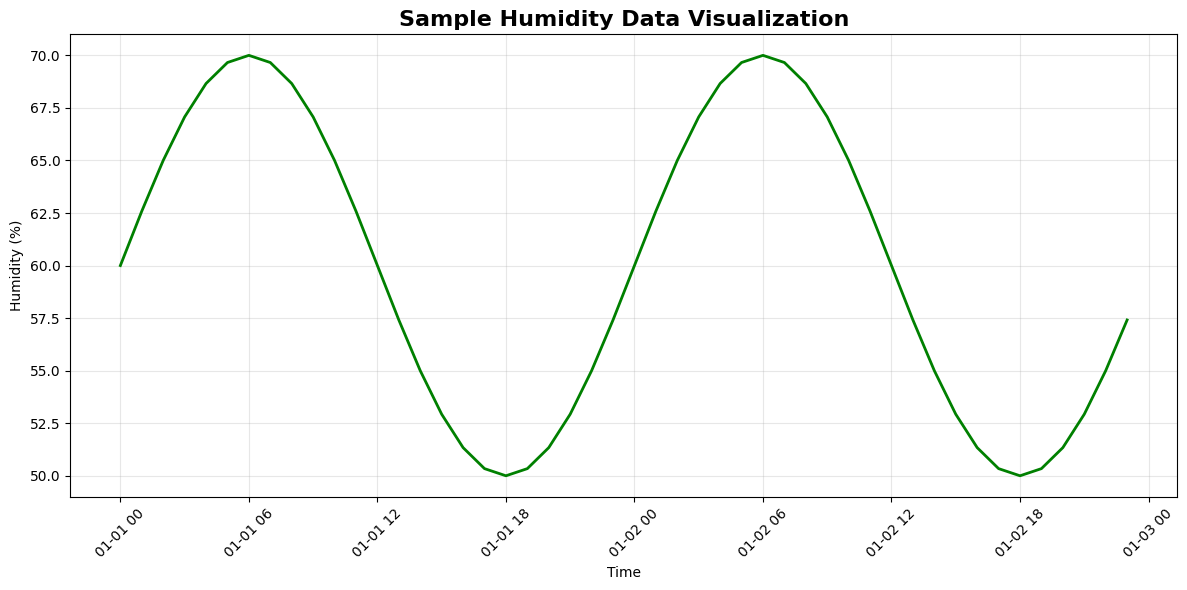

In [44]:
# Create rainfall/humidity visualization
if 'plot_data' in locals() and plot_data:
    # Determine if we have rainfall and/or humidity
    has_rain = any(v is not None for v in rainfall_values)
    has_hum = any(h is not None for h in humidity_values)
    
    if has_rain and has_hum:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        ax1.plot(dates, rainfall_values, 'b-', linewidth=1.5, alpha=0.8)
        ax1.set_ylabel('Rainfall (mm)')
        ax1.set_title(f'Hong Kong Rainfall and Humidity - {year}')
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(dates, humidity_values, 'g-', linewidth=1.5, alpha=0.8)
        ax2.set_ylabel('Humidity (%)')
        ax2.set_xlabel('Date and Time')
        ax2.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    elif has_rain:
        plt.figure(figsize=(12, 6))
        plt.plot(dates, rainfall_values, 'b-', linewidth=1.5, alpha=0.8)
        plt.title(f'Hong Kong Rainfall - {year}', fontsize=14, fontweight='bold')
        plt.xlabel('Date and Time')
        plt.ylabel('Rainfall (mm)')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    elif has_hum:
        plt.figure(figsize=(12, 6))
        plt.plot(dates, humidity_values, 'g-', linewidth=1.5, alpha=0.8)
        plt.title(f'Hong Kong Humidity - {year}', fontsize=14, fontweight='bold')
        plt.xlabel('Date and Time')
        plt.ylabel('Humidity (%)')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No numeric rainfall or humidity values available to plot")
else:
    print("Creating sample visualizations as no real data is available")
    import numpy as np
    sample_times = [datetime.datetime(2023, 1, 1) + datetime.timedelta(hours=i) for i in range(48)]
    sample_rain = [0.0 if i%6 else 5.0 for i in range(48)]
    sample_hum = [60 + 10 * np.sin(2 * np.pi * i / 24) for i in range(48)]
    plt.figure(figsize=(12, 6))
    plt.plot(sample_times, sample_rain, 'b-', linewidth=2)
    plt.title('Sample Rainfall Data Visualization', fontsize=16, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('Rainfall (mm)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(sample_times, sample_hum, 'g-', linewidth=2)
    plt.title('Sample Humidity Data Visualization', fontsize=16, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('Humidity (%)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [45]:
# Create additional visualization styles (rainfall & humidity)
if 'plot_data' in locals() and plot_data and len(plot_data) > 10:
    # Prepare series (allow None values)
    rainfall_values = [p[1] for p in plot_data]
    humidity_values = [p[2] for p in plot_data]
    has_rain = any(v is not None for v in rainfall_values)
    has_hum = any(h is not None for h in humidity_values)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Top-left: Line plot of rainfall (if available)
    if has_rain:
        axes[0, 0].plot(dates, rainfall_values, 'b-', alpha=0.7)
        axes[0, 0].set_title('Rainfall Over Time')
        axes[0, 0].set_ylabel('Rainfall (mm)')
    else:
        axes[0, 0].text(0.5, 0.5, 'No rainfall data', ha='center', va='center')
        axes[0, 0].set_title('Rainfall Over Time')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Top-right: Scatter rainfall vs humidity (if humidity present), else scatter rainfall over time
    if has_hum:
        # Scatter: rainfall vs humidity (only plot pairs where both exist)
        x = [r for r, h in zip(rainfall_values, humidity_values) if r is not None and h is not None]
        y = [h for r, h in zip(rainfall_values, humidity_values) if r is not None and h is not None]
        if x and y:
            axes[0, 1].scatter(x, y, alpha=0.6, s=20)
            axes[0, 1].set_xlabel('Rainfall (mm)')
            axes[0, 1].set_ylabel('Humidity (%)')
            axes[0, 1].set_title('Rainfall vs Humidity')
        else:
            axes[0, 1].text(0.5, 0.5, 'No paired rainfall/humidity samples', ha='center', va='center')
            axes[0, 1].set_title('Rainfall vs Humidity')
    else:
        # Fallback: scatter rainfall over time if humidity not available
        if has_rain:
            axes[0, 1].scatter(dates, rainfall_values, alpha=0.6, s=10)
            axes[0, 1].set_title('Rainfall Scatter')
            axes[0, 1].set_ylabel('Rainfall (mm)')
        else:
            axes[0, 1].text(0.5, 0.5, 'No data', ha='center', va='center')
            axes[0, 1].set_title('Rainfall Scatter')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Bottom-left: Histogram of rainfall (or humidity if rainfall missing)
    if has_rain:
        valid_rain = [v for v in rainfall_values if v is not None]
        axes[1, 0].hist(valid_rain, bins=20, alpha=0.7, edgecolor='black')
        axes[1, 0].set_title('Rainfall Distribution')
        axes[1, 0].set_xlabel('Rainfall (mm)')
        axes[1, 0].set_ylabel('Frequency')
    elif has_hum:
        valid_hum = [h for h in humidity_values if h is not None]
        axes[1, 0].hist(valid_hum, bins=20, alpha=0.7, edgecolor='black', color='green')
        axes[1, 0].set_title('Humidity Distribution')
        axes[1, 0].set_xlabel('Humidity (%)')
        axes[1, 0].set_ylabel('Frequency')
    else:
        axes[1, 0].text(0.5, 0.5, 'No numeric data', ha='center', va='center')
    
    # Bottom-right: Box plot(s)
    box_data = []
    labels = []
    if has_rain:
        box_data.append([v for v in rainfall_values if v is not None])
        labels.append('Rainfall (mm)')
    if has_hum:
        box_data.append([h for h in humidity_values if h is not None])
        labels.append('Humidity (%)')
    if box_data:
        axes[1, 1].boxplot(box_data, labels=labels)
        axes[1, 1].set_title('Box Plot')
    else:
        axes[1, 1].text(0.5, 0.5, 'No numeric data', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for multiple visualizations")

Not enough data for multiple visualizations


## 7. SVG Drawing and Graphics

Finally, let's explore programmatic graphics creation using SVG. This demonstrates how we can create vector graphics using code.

In [50]:
# Create a basic SVG drawing (from draw_svg.py)
d = draw.Drawing(200, 100, origin='center')

# Draw an irregular polygon
d.append(draw.Lines(-80, 45,
                     70, 49,
                     95, -49,
                    -90, -40,
                    close=False,
            fill='#eeee00',
            stroke='black'))

# Save the SVG
svg_filename = 'irregular-polygon.svg'
d.save_svg(svg_filename)
print(f"SVG saved as: {svg_filename}")

# Display the SVG as text
print("\nSVG content:")
print(d.as_svg())

SVG saved as: irregular-polygon.svg

SVG content:
<?xml version="1.0" encoding="UTF-8"?>
<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"
     width="200" height="100" viewBox="-100.0 -50.0 200 100">
<defs>
</defs>
<path d="M-80,45 L70,49 L95,-49 L-90,-40" fill="#eeee00" stroke="black" />
</svg>


In [51]:
# Create more complex SVG graphics
# Example 1: Geometric shapes
d2 = draw.Drawing(400, 300, origin='center')

# Add a rectangle
d2.append(draw.Rectangle(-150, -100, 100, 80, fill='lightblue', stroke='navy', stroke_width=2))

# Add a circle
d2.append(draw.Circle(50, 0, 40, fill='red', stroke='darkred', stroke_width=2))

# Add some text
d2.append(draw.Text('Week 02 Graphics', 20, -120, -50, fill='black', font_family='Arial', font_weight='bold'))

# Add lines
d2.append(draw.Line(-100, 50, 100, 50, stroke='green', stroke_width=3))
d2.append(draw.Line(0, -80, 0, 80, stroke='purple', stroke_width=2, stroke_dasharray='5,5'))

# Save and display
geometric_svg = 'geometric-shapes.svg'
d2.save_svg(geometric_svg)
print(f"Geometric shapes SVG saved as: {geometric_svg}")
print(f"SVG dimensions: {d2.width} x {d2.height}")

Geometric shapes SVG saved as: geometric-shapes.svg
SVG dimensions: 400 x 300


In [54]:
# Example 2: Data visualization in SVG
# Create a simple bar chart of tide statistics

# Define values as an empty list to use sample data branch
values = []

d3 = draw.Drawing(500, 300, origin=(0, 0))

# Sample data for visualization
if 'values' in locals() and values:
    # Use actual tide data
    stats = {
        'Max': max(values),
        'Min': abs(min(values)),  # Use absolute value for visualization
        'Avg': sum(values)/len(values)
    }
else:
    # Use sample data
    stats = {'Max': 3.2, 'Min': 0.5, 'Avg': 1.8}

# Draw title
d3.append(draw.Text('Tide Statistics', 24, 250, 30, text_anchor='middle', 
                   fill='black', font_family='Arial', font_weight='bold'))

# Draw bars
bar_width = 60
bar_spacing = 100
start_x = 100
start_y = 250
max_height = 150
scale = max_height / max(stats.values())

colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']

for i, (label, value) in enumerate(stats.items()):
    x = start_x + i * bar_spacing
    height = value * scale
    
    # Draw bar
    d3.append(draw.Rectangle(x, start_y - height, bar_width, height,
                           fill=colors[i], stroke='black', stroke_width=1))
    
    # Draw label
    d3.append(draw.Text(label, 14, x + bar_width/2, start_y + 20,
                       text_anchor='middle', fill='black'))
    
    # Draw value
    d3.append(draw.Text(f'{value:.1f}m', 12, x + bar_width/2, start_y - height - 10,
                       text_anchor='middle', fill='black', font_weight='bold'))

# Save the chart
chart_svg = 'tide-chart.svg'
d3.save_svg(chart_svg)
print(f"Tide statistics chart saved as: {chart_svg}")
print(f"Chart shows: {stats}")

Tide statistics chart saved as: tide-chart.svg
Chart shows: {'Max': 3.2, 'Min': 0.5, 'Avg': 1.8}


## Summary and Key Takeaways

In this Week 02 notebook, we have covered:

### 1. **Environment Management**
- Used `.env` files to store configuration
- Loaded environment variables with `python-dotenv`
- Managed sensitive data and configuration separately from code

### 2. **Web Scraping Techniques**
- Created reusable utility functions for web scraping
- Implemented caching to avoid repeated requests
- Handled both HTML and JSON data formats

### 3. **Data Processing**
- Parsed HTML using XPath selectors
- Extracted structured data from web pages
- Converted data to CSV format for further analysis
- Handled date/time data and numeric conversions

### 4. **Data Visualization**
- Created multiple types of plots with matplotlib
- Displayed time-series data effectively
- Generated statistical summaries and distributions

### 5. **Programmatic Graphics**
- Created vector graphics with SVG
- Generated geometric shapes and text
- Built data visualizations using SVG elements

### **Best Practices Demonstrated**
- Error handling for network requests and data parsing
- Code organization with utility functions
- Configuration management with environment variables
- Data validation and cleaning
- Multiple visualization approaches for different insights

### **Next Steps**
- Experiment with different XPath selectors for other websites
- Try scraping different data sources
- Create more complex SVG visualizations
- Combine multiple data sources for richer analysis

In [55]:
# Clean up - list all files created during this session
created_files = []
possible_files = ['test_page.html', 'tides_processed.csv', 'irregular-polygon.svg', 
                 'geometric-shapes.svg', 'tide-chart.svg'] + \
                [f'city-{i}.json' for i in range(1, 10)]

for filename in possible_files:
    if os.path.exists(filename):
        created_files.append(filename)

print("Files created during this session:")
for file in created_files:
    file_size = os.path.getsize(file)
    print(f"  {file} ({file_size} bytes)")

print(f"\nTotal files created: {len(created_files)}")
print("\nWeek 02 notebook completed successfully! 🎉")

Files created during this session:
  test_page.html (429 bytes)
  tides_processed.csv (28642 bytes)
  irregular-polygon.svg (280 bytes)
  geometric-shapes.svg (641 bytes)
  tide-chart.svg (1210 bytes)

Total files created: 5

Week 02 notebook completed successfully! 🎉
